Starting solar system simulation...
Simulation completed with 2001 time steps.


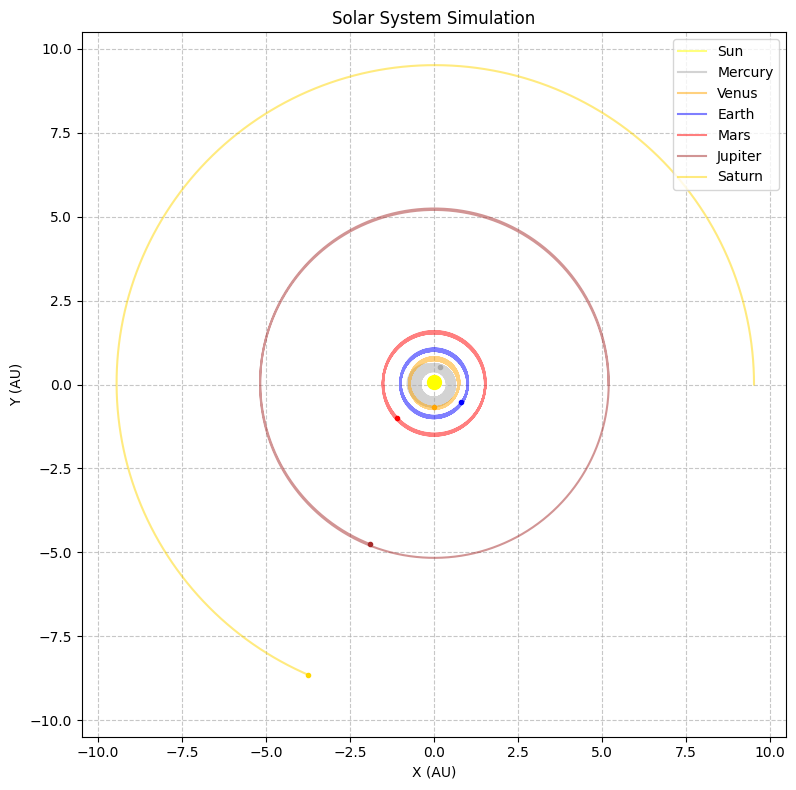

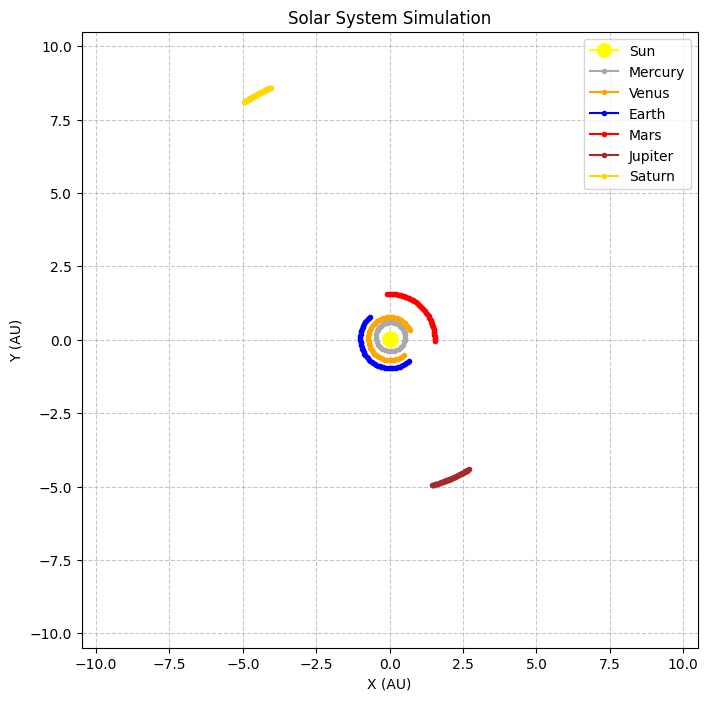


Final positions and velocities:
0. 1.0e+00 M_sun: Pos=(0.011, 0.072) AU, Vel=(-0.003, 0.004) AU/yr
1. 1.7e-07 M_sun: Pos=(0.171, 0.532) AU, Vel=(-8.114, 5.615) AU/yr
2. 2.4e-06 M_sun: Pos=(0.012, -0.668) AU, Vel=(7.303, 0.010) AU/yr
3. 3.0e-06 M_sun: Pos=(0.816, -0.527) AU, Vel=(3.738, 5.039) AU/yr
4. 3.2e-07 M_sun: Pos=(-1.087, -0.987) AU, Vel=(3.531, -3.653) AU/yr
5. 9.6e-04 M_sun: Pos=(-1.911, -4.750) AU, Vel=(2.560, -1.022) AU/yr
6. 2.9e-04 M_sun: Pos=(-3.751, -8.643) AU, Vel=(1.871, -0.811) AU/yr


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from ode_solver import solve_ode, EulerRichardson

def n_body(t, x, p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                r_ij.append(displacement)

            r_ij = np.array(r_ij)

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))

            # Calculate gravitational force magnitude (avoid division by zero)
            if r > 1e-10:  # Add a small threshold to prevent division by zero
                force_mag = -G * masses[i] * masses[j] / (r**3)
            else:
                force_mag = 0

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]

    return dxdt

def setup_solar_system(dimensions=2):
    """
    Set up initial conditions for the solar system simulation.

    Parameters:
    dimensions (int): Number of spatial dimensions (2 or 3)

    Returns:
    tuple: (y0, p) initial state vector and parameters
    """
    # Use astronomical units (AU), solar masses, and years
    # G = 4π² AU³/(M_sun * year²)
    G = 4 * np.pi**2  # gravitational constant in AU^3/year^2/M_sun

    # Bodies: Sun, Mercury, Venus, Earth, Mars, Jupiter, Saturn (simplified)
    masses = [1.0, 1.66e-7, 2.45e-6, 3.04e-6, 3.23e-7, 9.55e-4, 2.86e-4]

    # Number of bodies
    n_bodies = len(masses)

    # Create parameter dictionary
    p = {
        'G': G,
        'm': masses,
        'dimension': dimensions,
        'fix_first': False  # Set to True if you want to fix the Sun in place
    }

    # Semimajor axes of orbits in AU
    a = [0.0, 0.387, 0.723, 1.0, 1.524, 5.203, 9.537]

    # Simplified: all planets start in x-axis with proper velocity in y-direction
    y0 = np.zeros(2 * dimensions * n_bodies)

    # Set initial positions (all in x-axis)
    for i in range(n_bodies):
        y0[i*dimensions] = a[i]

    # Set initial velocities (circular orbits)
    # For a circular orbit, v = sqrt(GM_central/r)
    for i in range(1, n_bodies):  # Skip the Sun
        orbital_velocity = np.sqrt(G * masses[0] / a[i])
        y0[n_bodies*dimensions + i*dimensions + 1] = orbital_velocity  # velocity in y-direction

    return y0, p

def plot_solar_system_orbits(t, y, p, save_animation=False):
    """
    Plot the solar system orbits from simulation results.

    Parameters:
    t (np.array): Time points
    y (np.array): Solution array where each row is a state vector at time t
    p (dict): Parameter dictionary
    save_animation (bool): Whether to save the animation as a file
    """
    dimensions = p['dimension']
    n_bodies = len(p['m'])

    # Planet names for the legend
    planet_names = ['Sun', 'Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn']

    # Colors for each body
    colors = ['yellow', 'darkgray', 'orange', 'blue', 'red', 'brown', 'gold']

    # Set up the figure
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)

    # Plot the orbits
    for i in range(n_bodies):
        x_idx = i * dimensions
        y_idx = i * dimensions + 1

        # Extract x and y positions for this body
        x = y[:, x_idx]
        y_pos = y[:, y_idx]

        # Plot the orbit
        ax.plot(x, y_pos, '-', color=colors[i], alpha=0.5, label=planet_names[i])

        # Mark the final position
        ax.plot(x[-1], y_pos[-1], 'o', color=colors[i], markersize=max(3, 10 * p['m'][i]**(1/3)))

    # Add a legend
    ax.legend(loc='upper right')

    # Set axis limits to show all orbits
    max_orbit = np.max(np.abs(y[:, :n_bodies*dimensions])) * 1.1
    ax.set_xlim(-max_orbit, max_orbit)
    ax.set_ylim(-max_orbit, max_orbit)

    # Add labels and title
    ax.set_xlabel('X (AU)')
    ax.set_ylabel('Y (AU)')
    ax.set_title('Solar System Simulation')

    # Make sure the aspect ratio is equal
    ax.set_aspect('equal')

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot
    plt.savefig('solar_system_orbits.png', dpi=300)

    # Create animation if requested
    if save_animation:
        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot settings
        max_orbit = np.max(np.abs(y[:, :n_bodies*dimensions])) * 1.1
        ax.set_xlim(-max_orbit, max_orbit)
        ax.set_ylim(-max_orbit, max_orbit)
        ax.set_aspect('equal')
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.set_xlabel('X (AU)')
        ax.set_ylabel('Y (AU)')
        ax.set_title('Solar System Simulation')

        # Initialize empty plots for each body
        plots = []
        for i in range(n_bodies):
            plot, = ax.plot([], [], 'o-', color=colors[i], markersize=max(3, 10 * p['m'][i]**(1/3)), label=planet_names[i])
            plots.append(plot)

        # Add legend
        ax.legend(loc='upper right')

        # Animation update function
        def update(frame):
            # We'll use fewer frames from the simulation for smoother animation
            idx = min(frame * 10, len(t) - 1)

            for i, plot in enumerate(plots):
                x_idx = i * dimensions
                y_idx = i * dimensions + 1

                # Trail length (show recent history of orbit)
                trail_length = 50
                start_idx = max(0, idx - trail_length)

                # Update data
                plot.set_data(y[start_idx:idx+1, x_idx], y[start_idx:idx+1, y_idx])

            return plots

        # Create the animation
        frames = min(100, len(t) - 1)  # Limit to 100 frames for efficiency
        ani = FuncAnimation(fig, update, frames=frames, interval=50, blit=True)

        # Save the animation
        ani.save('solar_system_animation.mp4', writer='ffmpeg', fps=20, dpi=100)

    plt.show()

def main():
    # Set up the simulation
    dimensions = 2  # 2D simulation
    y0, p = setup_solar_system(dimensions=dimensions)

    # Define time span (in years)
    t_span = [0, 20]  # 20 years simulation

    # Define time step
    dt = 0.01  # 0.01 years = ~3.65 days

    # Run the simulation using the solve_ode function
    print("Starting solar system simulation...")
    t, y = solve_ode(n_body, t_span, y0, EulerRichardson, p, first_step=dt)
    print(f"Simulation completed with {len(t)} time steps.")

    # Plot the results
    plot_solar_system_orbits(t, y, p, save_animation=True)

    # Calculate and print some statistics
    n_bodies = len(p['m'])
    dimensions = p['dimension']

    print("\nFinal positions and velocities:")
    for i in range(n_bodies):
        pos_idx = i * dimensions
        vel_idx = n_bodies * dimensions + i * dimensions

        if dimensions == 2:
            pos = y[-1, pos_idx:pos_idx+2]
            vel = y[-1, vel_idx:vel_idx+2]
            print(f"{i}. {p['m'][i]:.1e} M_sun: Pos=({pos[0]:.3f}, {pos[1]:.3f}) AU, "
                  f"Vel=({vel[0]:.3f}, {vel[1]:.3f}) AU/yr")
        else:  # 3D
            pos = y[-1, pos_idx:pos_idx+3]
            vel = y[-1, vel_idx:vel_idx+3]
            print(f"{i}. {p['m'][i]:.1e} M_sun: Pos=({pos[0]:.3f}, {pos[1]:.3f}, {pos[2]:.3f}) AU, "
                  f"Vel=({vel[0]:.3f}, {vel[1]:.3f}, {vel[2]:.3f}) AU/yr")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ode_solver import solve_ode, Euler, EulerCromer, EulerRichardson, RungeKutta, RK45, error_scale

def n_body(t, x, p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                r_ij.append(displacement)

            r_ij = np.array(r_ij)

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))

            # Calculate gravitational force magnitude (avoid division by zero)
            if r > 1e-10:  # Add a small threshold to prevent division by zero
                force_mag = -G * masses[i] * masses[j] / (r**3)
            else:
                force_mag = 0

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]

    return dxdt

def setup_earth_sun_system():
    """Set up a simple Earth-Sun system for testing integration methods"""
    # Use astronomical units (AU), solar masses, and years
    G = 4 * np.pi**2  # gravitational constant in AU^3/year^2/M_sun

    # Bodies: Sun, Earth
    masses = [1.0, 3.0e-6]

    # Create parameter dictionary
    p = {
        'G': G,
        'm': masses,
        'dimension': 2,
        'fix_first': False
    }

    # Earth starts at (1, 0) AU with velocity (0, 2π) AU/year
    # (approximately circular orbit)
    y0 = np.array([0.0, 1.0, 0.0, 0.0, 2*np.pi, 0.0])

    return y0, p

def calculate_energy(y, p):
    """Calculate total energy of the system (kinetic + potential)"""
    n_bodies = len(p['m'])
    dimensions = p['dimension']
    G = p['G']
    masses = np.array(p['m'])

    # Extract positions and velocities
    positions = y[:n_bodies*dimensions].reshape(n_bodies, dimensions)
    velocities = y[n_bodies*dimensions:].reshape(n_bodies, dimensions)

    # Calculate kinetic energy: 1/2 * m * v^2
    kinetic = 0
    for i in range(n_bodies):
        v_squared = np.sum(velocities[i]**2)
        kinetic += 0.5 * masses[i] * v_squared

    # Calculate potential energy: -G * m1 * m2 / r
    potential = 0
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):
            r_ij = positions[i] - positions[j]
            r = np.sqrt(np.sum(r_ij**2))
            potential -= G * masses[i] * masses[j] / r

    return kinetic + potential

def calculate_angular_momentum(y, p):
    """Calculate total angular momentum of the system"""
    n_bodies = len(p['m'])
    dimensions = p['dimension']
    masses = np.array(p['m'])

    # Extract positions and velocities
    positions = y[:n_bodies*dimensions].reshape(n_bodies, dimensions)
    velocities = y[n_bodies*dimensions:].reshape(n_bodies, dimensions)

    # Calculate angular momentum: r × p (cross product)
    angular_momentum = np.zeros(3)  # Even in 2D, angular momentum is a 3D vector

    for i in range(n_bodies):
        # For 2D, we're only interested in the z-component
        if dimensions == 2:
            r = np.append(positions[i], 0)  # Add z=0
            v = np.append(velocities[i], 0)  # Add vz=0
        else:
            r = positions[i]
            v = velocities[i]

        p_i = masses[i] * v
        angular_momentum += np.cross(r, p_i)

    # For 2D, return only the z-component
    if dimensions == 2:
        return angular_momentum[2]
    return angular_momentum

def compare_integration_methods(dt_values, t_span, methods, method_names):
    """
    Compare different integration methods for the Earth-Sun system.

    Parameters:
    dt_values (list): List of time steps to test
    t_span (list): Time span [t0, tf] for the simulation
    methods (list): List of integration method functions
    method_names (list): Names of the integration methods

    Returns:
    tuple: (method_errors, energy_errors, energy_drifts)
    """
    # Get initial conditions
    y0, p = setup_earth_sun_system()

    # Get reference solution using the most accurate method with smallest time step
    print("Computing reference solution...")
    t_ref, y_ref = solve_ode(n_body, t_span, y0, RK45, p,
                           first_step=min(dt_values)/10,
                           tol=1e-10, h_max=0.01, h_min=1e-6)

    # Interpolate reference solution to compare with other methods
    from scipy.interpolate import interp1d

    # Earth position from reference solution
    x_earth_ref = y_ref[:, 1]
    y_earth_ref = y_ref[:, 2]

    # Create interpolation function
    x_earth_interp = interp1d(t_ref, x_earth_ref, kind='cubic')
    y_earth_interp = interp1d(t_ref, y_earth_ref, kind='cubic')

    # Initial energy and angular momentum
    initial_energy = calculate_energy(y0, p)
    initial_angular_momentum = calculate_angular_momentum(y0, p)

    # Store errors for each method and time step
    method_errors = {name: [] for name in method_names}
    energy_errors = {name: [] for name in method_names}
    energy_drifts = {name: [] for name in method_names}

    # Test each method with different time steps
    for dt in dt_values:
        print(f"Testing with dt = {dt}...")

        for method, name in zip(methods, method_names):
            print(f"  Method: {name}")

            # Run simulation
            t, y = solve_ode(n_body, t_span, y0, method, p, first_step=dt)

            # Calculate error compared to reference solution
            earth_x = y[:, 1]  # Earth x position
            earth_y = y[:, 2]  # Earth y position

            # Interpolate reference solution to match simulation time points
            ref_x = x_earth_interp(t)
            ref_y = y_earth_interp(t)

            # Calculate RMS error
            position_errors = np.sqrt((earth_x - ref_x)**2 + (earth_y - ref_y)**2)
            rms_error = np.sqrt(np.mean(position_errors**2))
            method_errors[name].append(rms_error)

            # Calculate energy conservation error
            energies = np.array([calculate_energy(y[i], p) for i in range(len(t))])
            energy_error = np.max(np.abs((energies - initial_energy) / initial_energy))
            energy_errors[name].append(energy_error)

            # Calculate energy drift (slope of energy vs time)
            from scipy.stats import linregress
            slope, _, _, _, _ = linregress(t, energies)
            energy_drifts[name].append(abs(slope))

    return method_errors, energy_errors, energy_drifts

def plot_errors(dt_values, method_errors, energy_errors, energy_drifts, method_names):
    """Plot error comparisons between different methods"""
    plt.figure(figsize=(15, 10))

    # Position error plot
    plt.subplot(1, 3, 1)
    for name in method_names:
        plt.loglog(dt_values, method_errors[name], 'o-', label=name)

    # Add reference lines for different orders of convergence
    dt_ref = np.array([min(dt_values), max(dt_values)])
    for order, style in zip([1, 2, 4], ['k:', 'k--', 'k-.']):
        plt.loglog(dt_ref, 0.01 * (dt_ref/dt_ref[0])**order, style,
                 label=f'Order {order}')

    plt.xlabel('Time Step (dt)')
    plt.ylabel('RMS Position Error (AU)')
    plt.title('Position Error vs Time Step')
    plt.legend()
    plt.grid(True)

    # Energy conservation error plot
    plt.subplot(1, 3, 2)
    for name in method_names:
        plt.loglog(dt_values, energy_errors[name], 'o-', label=name)

    plt.xlabel('Time Step (dt)')
    plt.ylabel('Relative Energy Error')
    plt.title('Energy Conservation Error')
    plt.legend()
    plt.grid(True)

    # Energy drift plot
    plt.subplot(1, 3, 3)
    for name in method_names:
        plt.loglog(dt_values, energy_drifts[name], 'o-', label=name)

    plt.xlabel('Time Step (dt)')
    plt.ylabel('Energy Drift (per year)')
    plt.title('Energy Drift vs Time Step')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('integration_method_comparison.png', dpi=300)
    plt.show()

def plot_orbit_and_energy(method, dt, t_span):
    """Plot orbit and energy for a specific method and time step"""
    y0, p = setup_earth_sun_system()

    print(f"Running simulation with {method.__name__}, dt = {dt}...")
    t, y = solve_ode(n_body, t_span, y0, method, p, first_step=dt)

    # Calculate energy at each time step
    energies = np.array([calculate_energy(y[i], p) for i in range(len(t))])
    initial_energy = energies[0]
    relative_energy_error = (energies - initial_energy) / initial_energy

    # Calculate angular momentum at each time step
    angular_momenta = np.array([calculate_angular_momentum(y[i], p) for i in range(len(t))])
    initial_angular_momentum = angular_momenta[0]
    relative_angular_momentum_error = (angular_momenta - initial_angular_momentum) / initial_angular_momentum

    plt.figure(figsize=(15, 10))

    # Plot the orbit
    plt.subplot(2, 2, 1)

    # Sun
    plt.plot(y[:, 0], y[:, 1], 'yo', markersize=10, label='Sun')

    # Earth orbit
    plt.plot(y[:, 2], y[:, 3], 'b-', label='Earth Orbit')
    plt.plot(y[-1, 2], y[-1, 3], 'bo', markersize=5)

    plt.xlabel('X (AU)')
    plt.ylabel('Y (AU)')
    plt.title(f'Earth-Sun System - {method.__name__} (dt = {dt})')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()

    # Plot energy vs time
    plt.subplot(2, 2, 2)
    plt.plot(t, energies, 'g-')
    plt.xlabel('Time (years)')
    plt.ylabel('Total Energy')
    plt.title('System Energy vs Time')
    plt.grid(True)

    # Plot relative energy error
    plt.subplot(2, 2, 3)
    plt.plot(t, relative_energy_error * 100, 'r-')
    plt.xlabel('Time (years)')
    plt.ylabel('Relative Energy Error (%)')
    plt.title('Energy Conservation Error')
    plt.grid(True)

    # Plot relative angular momentum error
    plt.subplot(2, 2, 4)
    plt.plot(t, relative_angular_momentum_error * 100, 'm-')
    plt.xlabel('Time (years)')
    plt.ylabel('Relative Angular Momentum Error (%)')
    plt.title('Angular Momentum Conservation Error')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{method.__name__}_dt_{dt}.png', dpi=300)
    plt.show()

def main():
    # Define methods to compare
    methods = [Euler, EulerCromer, EulerRichardson, RungeKutta]
    method_names = ['Euler', 'Euler-Cromer', 'Euler-Richardson', 'Runge-Kutta-4']

    # Define time steps to test
    dt_values = [0.1, 0.05, 0.02, 0.01, 0.005]

    # Define time span (1 Earth year)
    t_span = [0, 1.0]

    # Compare methods
    method_errors, energy_errors, energy_drifts = compare_integration_methods(
        dt_values, t_span, methods, method_names)

    # Plot error comparisons
    plot_errors(dt_values, method_errors, energy_errors, energy_drifts, method_names)

    # Plot orbits and energy for a specific method and time step
    plot_orbit_and_energy(RungeKutta, 0.01, [0, 10.0])  # 10 years with RK4

    # Demonstrate Earth-Sun-Jupiter system
    earth_sun_jupiter()

def earth_sun_jupiter():
    """Simulate Earth-Sun-Jupiter system to demonstrate perturbations"""
    # Use astronomical units (AU), solar masses, and years
    G = 4 * np.pi**2  # gravitational constant in AU^3/year^2/M_sun

    # Bodies: Sun, Earth, Jupiter
    masses = [1.0, 3.0e-6, 9.55e-4]

    # Create parameter dictionary
    p = {
        'G': G,
        'm': masses,
        'dimension': 2,
        'fix_first': False
    }

    # Initial positions and velocities
    # Sun at origin
    # Earth at (1, 0) with velocity (0, 2π)
    # Jupiter at (5.2, 0) with velocity (0, 2.75)
    y0 = np.zeros(12)

    # Positions (x, y for each body)
    y0[0] = 0.0    # Sun x
    y0[1] = 0.0    # Sun y
    y0[2] = 1.0    # Earth x
    y0[3] = 0.0    # Earth y
    y0[4] = 5.2    # Jupiter x
    y0[5] = 0.0    # Jupiter y

    # Velocities (vx, vy for each body)
    y0[6] = 0.0        # Sun vx
    y0[7] = 0.0        # Sun vy
    y0[8] = 0.0        # Earth vx
    y0[9] = 2*np.pi    # Earth vy
    y0[10] = 0.0       # Jupiter vx
    y0[11] = 2.75      # Jupiter vy (√(GM/r) for circular orbit)

    # Adjust for center of mass motion
    # (This ensures the center of mass doesn't drift)
    total_mass = sum(masses)
    com_velocity = np.zeros(2)

    for i in range(len(masses)):
        com_velocity += masses[i] * y0[6+i*2:8+i*2]

    com_velocity /= total